In [18]:
def optimize_objective_from_qualitative_criteria(
    model,
    objective_reactions,
    qualitative_constraints,
    bounds=None,
    max_iter=1000,
    maxfun=1e7,
    initial_temp = 5230
):
    #import relevant packages
    import numpy as np
    import pandas as pd
    import cobra
    from cobra.io import read_sbml_model
    from scipy.optimize import dual_annealing
    from cobra import Model as CobraModel
    import matplotlib.pyplot as plt
    from itertools import combinations, product
    import math
    import warnings
    warnings.filterwarnings('ignore', 
                           message='DataFrame is highly fragmented', 
                           category=pd.errors.PerformanceWarning)
    """
    Optimizes objective coefficients for a COBRA model to best match qualitative flux constraints.
    Logs each function evaluation's normalized coefficients, accuracy, and flux values.

    Parameters:
    - model: COBRApy model
    - objective_reactions: list of reaction IDs to include in the objective
    - qualitative_constraints: dict of {reaction_id: expected_direction}, where direction ∈ {-1, 1}
    - bounds: list of (min, max) tuples for each reaction coefficient (default: (-1, 1) for all)
    - max_iter: int, number of maximum iterations for dual annealing

    Returns:
    - optimal_objective: dict of {reaction_id: normalized objective coefficient}
    - accuracy: float (0–1), final qualitative match accuracy
    - log_df: pandas DataFrame with columns ['coefficients', 'accuracy', 'fluxes']
    - message summarising the global minimum (maximum accuracy to experimental) and the fitted objective (reaction IDs and coefficients)
    - rounded_fluxes_df which stores the rounded fluxes for the criteria reactions each iterations, so we can analyse convergence
    - fig of the accuracy over time, to give an idea of convergence
    """
    
    #check the input data
    if not isinstance(model, CobraModel):
        raise TypeError("Check inputs: Model must be a cobra.Model.Model instance")
    if not isinstance(objective_reactions, list):
        raise TypeError("Check inputs: objective_reactions should be a list of reaction IDs in model")
    if not isinstance(qualitative_constraints, dict):
        raise TypeError("Check inputs: qualitative_constraints should be a dictionary of reactions IDs and expected direction of reaction, i.e. either 1 or -1, depending on whether this reaction is a production or consumption")
    invalid_values = {k: v for k, v in qualitative_constraints.items() if v not in {-1, 0, 1}}
    if invalid_values:
        raise ValueError(
            f"Invalid reaction direction values found: {invalid_values}. "
            "Each value in qualitative_constraints must be -1, 0, or 1."
        )

    for k,v in qualitative_constraints.items():
        if qualitative_constraints[k] == -1: # If you have specified that there is uptake of this metabolite
            if model.reactions.get_by_id(k).reversibility == False: # But if the inbuilt bounds don't allow uptake of this metabolite...
                model.reactions.get_by_id(k).lower_bound = -1000 # Update the model bounds to allow for metabolite uptake
                print('reaction bounds for:',k,'have been updated from 0,+1000 to -1000,+1000 to allow metabolite uptake')
            else:
                continue # If reversibility is already allowed
        else:
            continue # If criteria specifies 0 flux (0) or production (+1)

    print(f"Optimisation: User would like to fit an objective function including reactions: {objective_reactions} to predict a flux distribution best matching experimental data, measuring {len(qualitative_constraints)} reactions")

    # Global tracking variables for best solutions across all methods
    global_best_accuracy = -1
    global_best_solutions = []  # List of (solution_dict, accuracy, n, method, log_df, fig, agreement_df)
    
    selected_qualitative_reactions = list(qualitative_constraints.keys())

    #equal weight maximisations and minimisations for each reaction
    def get_equal_weight_sign_combinations(values, n):
        """
        Generate all combinations of n reactions with equal absolute weight values
        but testing all possible sign combinations (+/- for each reaction).
        """
        # Get all combinations of n reactions
        reaction_combos = list(combinations(values, n))
        equal_weight = 1.0 / n
        all_combos = []
        for combo in reaction_combos:
            # Generate all possible sign combinations for this set of reactions
            # Each reaction can have weight +equal_weight or -equal_weight
            sign_combinations = list(product([1, -1], repeat=n))
            
            for signs in sign_combinations:
                # Create dictionary with signed weights
                weighted_combo = {}
                for i, rxn in enumerate(combo):
                    weighted_combo[rxn] = signs[i] * equal_weight
                all_combos.append(weighted_combo)
        return all_combos

    print(f"Trying qualitative match via equal-weight objectives first...")
    model.objective = {}
    # Cache for tried combinations to avoid redundant optimizations
    seen_combos = set()
    
    for n in range(1, len(objective_reactions) + 1):
        print(f"Testing equal weight combinations for n={n}...")
        eq_combos = get_equal_weight_sign_combinations(objective_reactions, n)
        perfect_matches = []  # store all perfect matches at this n
        
        for combo in eq_combos:
            # Convert combo to a frozenset to use as a unique cache key
            combo_key = frozenset(combo.items())
            if combo_key in seen_combos:
                continue
            seen_combos.add(combo_key)
            
            for rxn_id in objective_reactions:
                model.reactions.get_by_id(rxn_id).objective_coefficient = 0.0
            for rxn_id, coeff in combo.items():
                model.reactions.get_by_id(rxn_id).objective_coefficient = coeff
            
            sol = model.optimize()
            if sol is None:
                continue
                
            fluxes = sol.fluxes[selected_qualitative_reactions]
            expected = np.array([qualitative_constraints[r] for r in selected_qualitative_reactions])
            rounded = np.where(np.abs(fluxes) < 1e-6, 0, np.sign(fluxes).astype(int))
            mismatch = np.count_nonzero(rounded != expected)
            accuracy = 1 - mismatch / len(expected)
            
            # Check if this is a perfect match
            if accuracy == 1.0:
                perfect_matches.append(combo)
                continue  # keep searching other combos of same n
            
            # Track best solutions globally
            if accuracy > global_best_accuracy:
                global_best_accuracy = accuracy
                global_best_solutions = [(combo, accuracy, n, "equal_weight", None, None, None)]
            elif accuracy == global_best_accuracy:
                global_best_solutions.append((combo, accuracy, n, "equal_weight", None, None, None))

        # After testing all combos for this n, check for perfect matches
        if perfect_matches:
            print(f"Found {len(perfect_matches)} perfect match(es) with equal weights for n={n}")
            return perfect_matches, 1.0, None, f"Perfect match(es) via equal weighting at n={n}", None, None

    print("No exact match found with equal weights. Starting simulated annealing...")

    if bounds is None:
        bounds = [(-1, 1)] * len(objective_reactions)

    # Check for lexicographic optimization
    for k,v in qualitative_constraints.items():
        if 'biomass' in k:
            if v == 1:
                print('User has specified that the cell is growing, therefore we will apply a lexicographic optimisation approach using growth maximisation constraints...')
                print('original number of objective reactions:',len(objective_reactions))
                model.objective = {model.reactions.get_by_id(k):1}
                solution = model.optimize()
                biomass_bounds = (solution.fluxes[k],solution.fluxes[k])
                model.reactions.get_by_id(k).bounds = biomass_bounds
                print('Bounds of biomass reaction updated to:',model.reactions.get_by_id(k).bounds)
                objective_reactions = [item for item in objective_reactions if item != k]
                print(k,'has been removed from objective reactions')
                print('updated number of objective reactions:',len(objective_reactions))
                break

    # Simulated annealing section
    for n in range(2, len(objective_reactions) + 1):
        print(f"Trying Dual Annealing with all combinations of {n} reactions...")
        for combo in combinations(objective_reactions, n):
            sub_bounds = [(-1, 1)] * n
            sub_reactions = list(combo)
            results_log = []
            best_mismatch = [len(selected_qualitative_reactions)]
            agreement_matrix = {}

            def evaluate_solution(c_raw):
                model.objective = {}
                if np.sum(np.abs(c_raw)) == 0:
                    c = np.zeros_like(c_raw)
                else:
                    c = c_raw / np.sum(np.abs(c_raw))

                for rxn_id in objective_reactions:
                    model.reactions.get_by_id(rxn_id).objective_coefficient = 0.0
                for i, rxn_id in enumerate(sub_reactions):
                    model.reactions.get_by_id(rxn_id).objective_coefficient = c[i]

                solution = model.optimize()

                flux_dict = {}
                agreement_dict = {}
                if solution is None:
                    accuracy = 0.0
                    mismatch_count = len(selected_qualitative_reactions)
                    for rxn_id in selected_qualitative_reactions:
                        flux_dict[rxn_id] = None
                        agreement_dict[rxn_id] = 0
                else:
                    fluxes = solution.fluxes[selected_qualitative_reactions]
                    expected = np.array([qualitative_constraints[rxn_id] for rxn_id in selected_qualitative_reactions])
                    rounded_fluxes = np.where(np.abs(fluxes) < 1e-6, 0, np.sign(fluxes).astype(int))
                    mismatch_count = np.count_nonzero(rounded_fluxes != expected)
                    accuracy = 1 - (mismatch_count / len(expected))
                    flux_dict = {rxn_id: flux for rxn_id, flux in zip(selected_qualitative_reactions, fluxes)}
                    agreement_dict = {rxn_id: int(round_f == exp) for rxn_id, round_f, exp in zip(selected_qualitative_reactions, rounded_fluxes, expected)}

                if mismatch_count <= best_mismatch[0]:
                    best_mismatch[0] = mismatch_count
                    results_log.append({
                        'coefficients': c.tolist(),
                        'accuracy': accuracy,
                        'fluxes': flux_dict
                    })

                # Log agreement per reaction
                agreement_matrix[len(results_log) - 1] = agreement_dict
                
                return mismatch_count

            result = dual_annealing(evaluate_solution, sub_bounds, maxiter=max_iter, initial_temp=initial_temp, maxfun=maxfun)

            if np.sum(np.abs(result.x)) == 0:
                scaled_coeffs = np.zeros_like(result.x)
            else:
                scaled_coeffs = result.x / np.sum(np.abs(result.x))

            for rxn_id in objective_reactions:
                model.reactions.get_by_id(rxn_id).objective_coefficient = 0.0
            for i, rxn_id in enumerate(sub_reactions):
                model.reactions.get_by_id(rxn_id).objective_coefficient = scaled_coeffs[i]

            solution = model.optimize()
            if solution is None:
                continue

            final_fluxes = solution.fluxes[selected_qualitative_reactions]
            expected = np.array([qualitative_constraints[rxn_id] for rxn_id in selected_qualitative_reactions])
            rounded_fluxes = np.where(np.abs(final_fluxes) < 1e-6, 0, np.sign(final_fluxes).astype(int))
            mismatch = np.count_nonzero(rounded_fluxes != expected)
            accuracy = 1 - mismatch / len(expected)

            # Create log_df and plots for this run
            log_df = pd.DataFrame(results_log)
            agreement_df = pd.DataFrame.from_dict(agreement_matrix, orient='index').T
            agreement_df.columns = [f"{i}" for i in agreement_df.columns]
            
            # Create plot
            sampled_df = log_df.iloc[::10] if len(log_df) > 10 else log_df
            fig, ax = plt.subplots(figsize=(11, 5))
            ax.plot(sampled_df.index, sampled_df['accuracy'], marker='o', linestyle='-', color='black')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Accuracy')
            ax.set_title(f'Accuracy Over Time (n={n}, reactions: {sub_reactions})')
            ax.grid(True)

            # After optimization
            if accuracy == 1.0:
                solution_dict = dict(zip(sub_reactions, scaled_coeffs))
                perfect_matches.append((solution_dict, log_df, fig, agreement_df))
                continue  # continue to gather other perfect matches of length n

            # Track best solutions globally
            solution_dict = dict(zip(sub_reactions, scaled_coeffs))
            if accuracy > global_best_accuracy:
                global_best_accuracy = accuracy
                global_best_solutions = [(solution_dict, accuracy, n, "dual_annealing", log_df, fig, agreement_df)]
            elif accuracy == global_best_accuracy:
                global_best_solutions.append((solution_dict, accuracy, n, "dual_annealing", log_df, fig, agreement_df))

        if perfect_matches:
            print(f"{len(perfect_matches)} perfect match(es) found via dual annealing for n={n}")
            # Unpack results
            coeffs_list = [item[0] for item in perfect_matches]
            return coeffs_list, 1.0, perfect_matches[0][1], f"Perfect match(es) via dual annealing at n={n}", perfect_matches[0][2], perfect_matches[0][3]


    # If we get here, no perfect match was found. Return the best solution(s) found
    if global_best_solutions:
        print(f"No perfect match found. Best accuracy achieved: {global_best_accuracy:.2%}")
        
        # Sort by priority: 1) lowest n, 2) prefer equal_weight over dual_annealing
        def sort_key(solution):
            sol_dict, acc, n, method, log_df, fig, agreement_df = solution
            return (n, method != "equal_weight")  # equal_weight gets priority (False < True)
        
        global_best_solutions.sort(key=sort_key)
        
        # Get the best n value
        best_n = global_best_solutions[0][2]
        
        # Filter solutions with the best n and best accuracy
        best_solutions_for_n = [sol for sol in global_best_solutions if sol[2] == best_n and sol[1] == global_best_accuracy]
        
        # Separate equal weight and dual annealing solutions
        equal_weight_solutions = [sol for sol in best_solutions_for_n if sol[3] == "equal_weight"]
        dual_annealing_solutions = [sol for sol in best_solutions_for_n if sol[3] == "dual_annealing"]
        
        if equal_weight_solutions:
            print(f"Returning {len(equal_weight_solutions)} equal weight solution(s) with accuracy {global_best_accuracy:.2%} for n={best_n}")
            # For equal weight solutions, we don't have detailed logs, so return basic info
            best_coeffs = [sol[0] for sol in equal_weight_solutions]
            description = f"Best equal weight solutions: accuracy {global_best_accuracy:.2%} for n={best_n}"
            return best_coeffs, global_best_accuracy, None, description, None, None
        
        elif dual_annealing_solutions:
            print(f"Returning {len(dual_annealing_solutions)} dual annealing solution(s) with accuracy {global_best_accuracy:.2%} for n={best_n}")
            # Return the first dual annealing solution with its logs
            best_sol = dual_annealing_solutions[0]
            sol_dict, acc, n, method, log_df, fig, agreement_df = best_sol
            all_coeffs = [sol[0] for sol in dual_annealing_solutions]
            description = f"Best dual annealing solutions: accuracy {global_best_accuracy:.2%} for n={best_n}"
            return all_coeffs, global_best_accuracy, log_df, description, fig, agreement_df

    print("No successful match found.")
    return None, 0.0, None, "No solution found", None, None

In [2]:
import numpy as np
import pandas as pd
import cobra
from cobra.io import read_sbml_model
from scipy.optimize import dual_annealing
from cobra import Model as CobraModel
import matplotlib.pyplot as plt

In [3]:
model = read_sbml_model('yeast-GEM.xml')

Set parameter Username
Set parameter LicenseID to value 2611274
Academic license - for non-commercial use only - expires 2026-01-17


In [4]:
criteria_higher = {'r_2111':1,'r_1714':-1,'r_1761':1,'r_1808':1,'r_1654':-1}
criteria_lower = {'r_2111':1,'r_1714':-1,'r_1761':0,'r_1808':0,'r_1654':-1}

In [19]:
%%time

criteria_1_higher = {'r_2111':1,'r_1714':-1}
objectives_higher = ['r_2111', 'r_1714', 'r_1761', 'r_1808', 'r_1654']

result_higher_1 = optimize_objective_from_qualitative_criteria(model,objectives_higher,criteria_1_higher,bounds=None, initial_temp = 9000, max_iter=5000)

Optimisation: User would like to fit an objective function including reactions: ['r_2111', 'r_1714', 'r_1761', 'r_1808', 'r_1654'] to predict a flux distribution best matching experimental data, measuring 2 reactions
Trying qualitative match via equal-weight objectives first...
Testing equal weight combinations for n=1...
Found 1 perfect match(es) with equal weights for n=1
CPU times: total: 1.16 s
Wall time: 1.17 s


In [20]:
scaled_objective, accuracy, criteria1_log_df, description, fig, agreement_df = result_higher_1

%store criteria1_log_df

criteria1_log_df.to_csv('iterative_criteria_1_log.csv', index=False)

Stored 'criteria1_log_df' (NoneType)


AttributeError: 'NoneType' object has no attribute 'to_csv'

Optimisation: User would like to fit an objective function including reactions: ['r_2111', 'r_1714', 'r_1761', 'r_1808', 'r_1654'] to predict a flux distribution best matching experimental data, measuring 3 reactions
Trying qualitative match via equal-weight objectives first...
Testing equal weight combinations for n=1...
Testing equal weight combinations for n=2...
Testing equal weight combinations for n=3...
Testing equal weight combinations for n=4...
Testing equal weight combinations for n=5...
No exact match found with equal weights. Starting simulated annealing...
Trying Dual Annealing with all combinations of 2 reactions...
1 perfect match(es) found via dual annealing for n=2
CPU times: total: 1h 51min 1s
Wall time: 1h 51min 31s


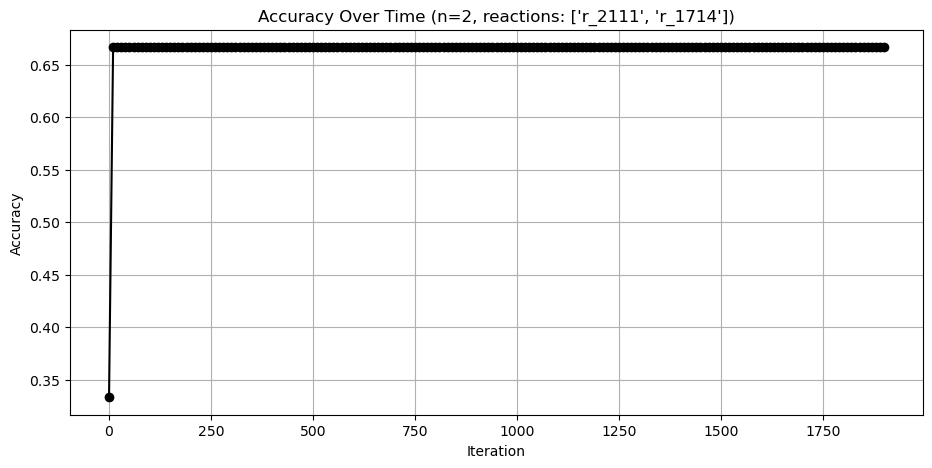

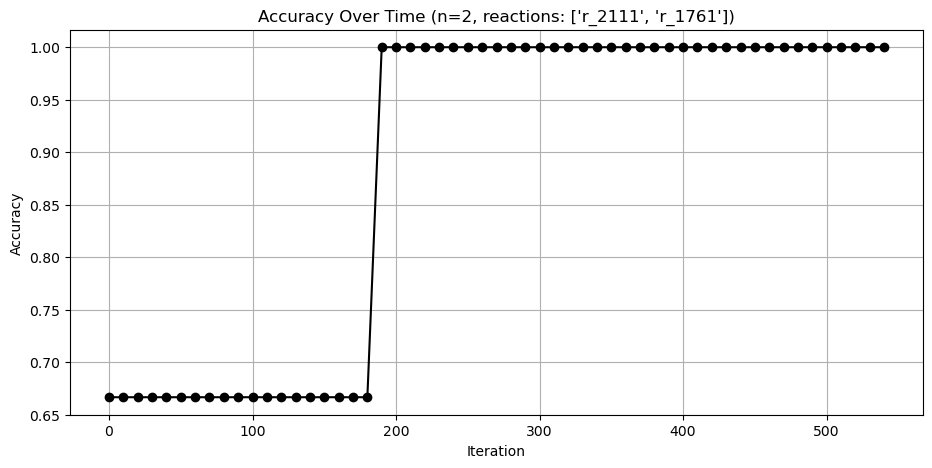

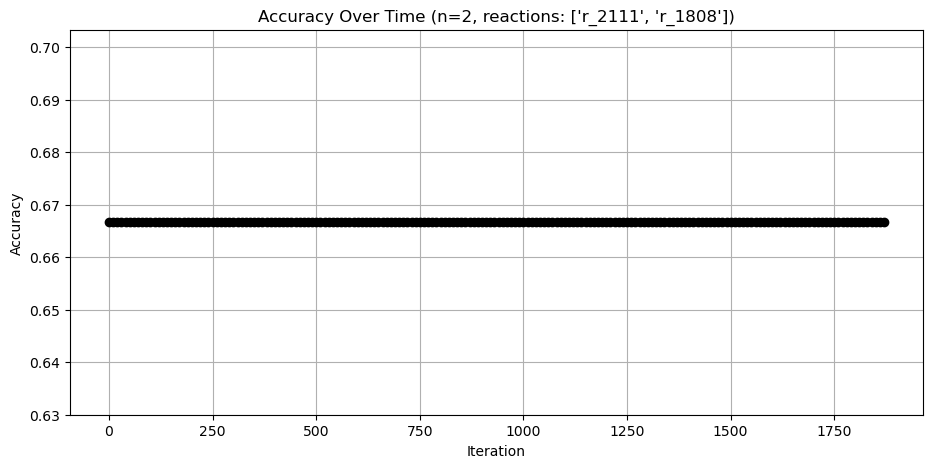

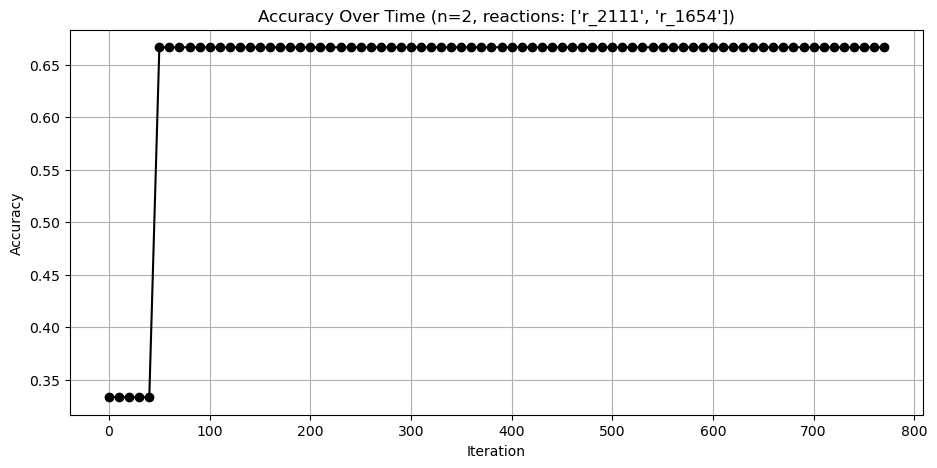

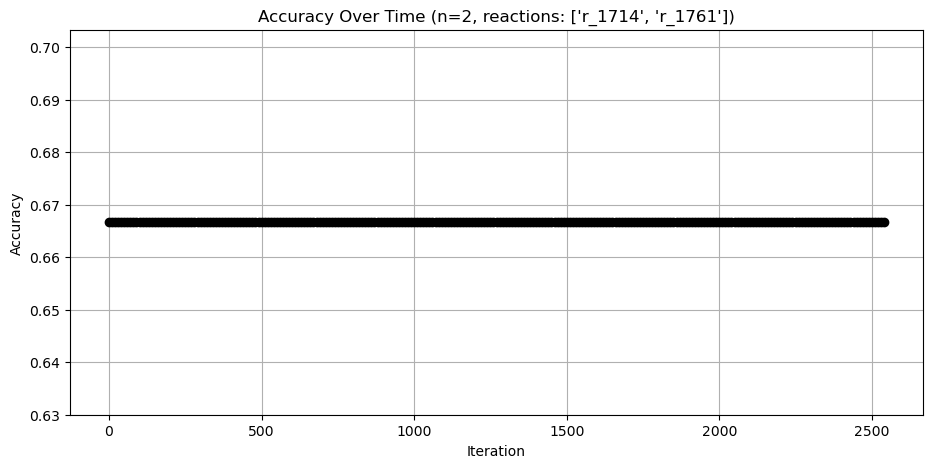

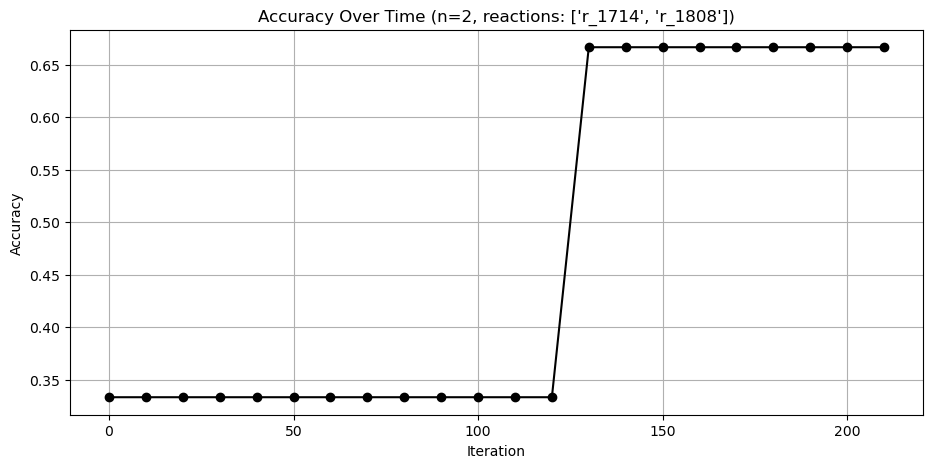

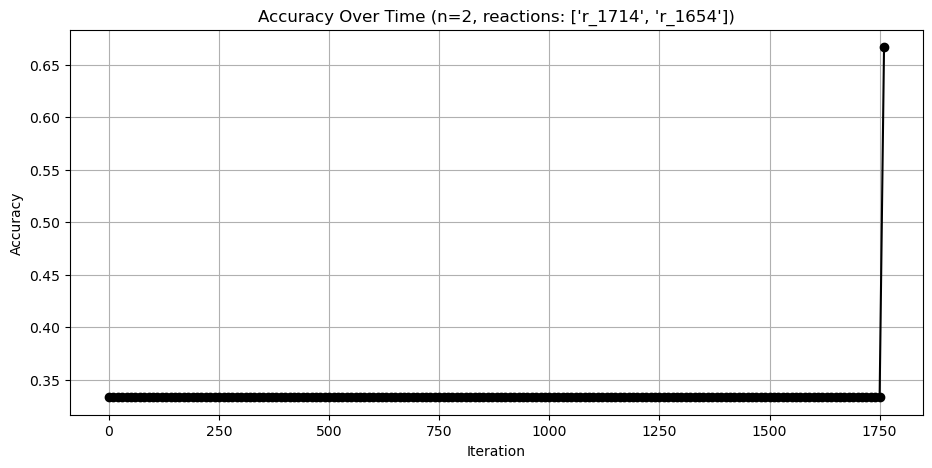

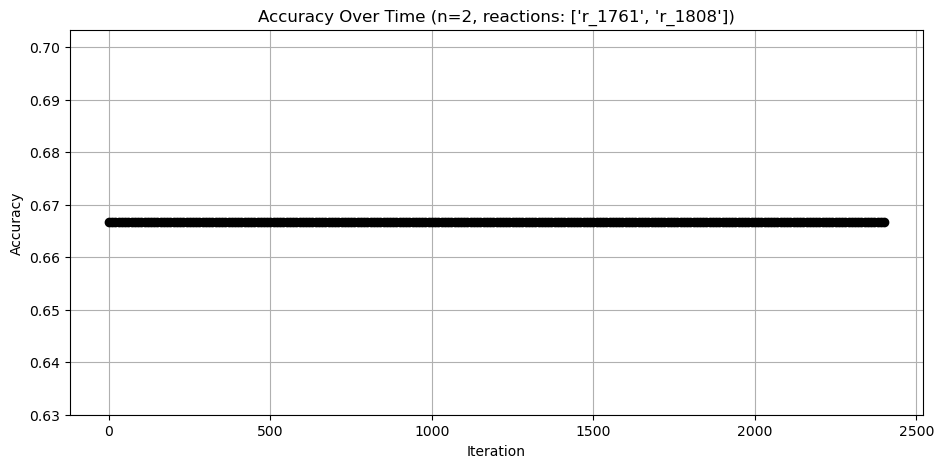

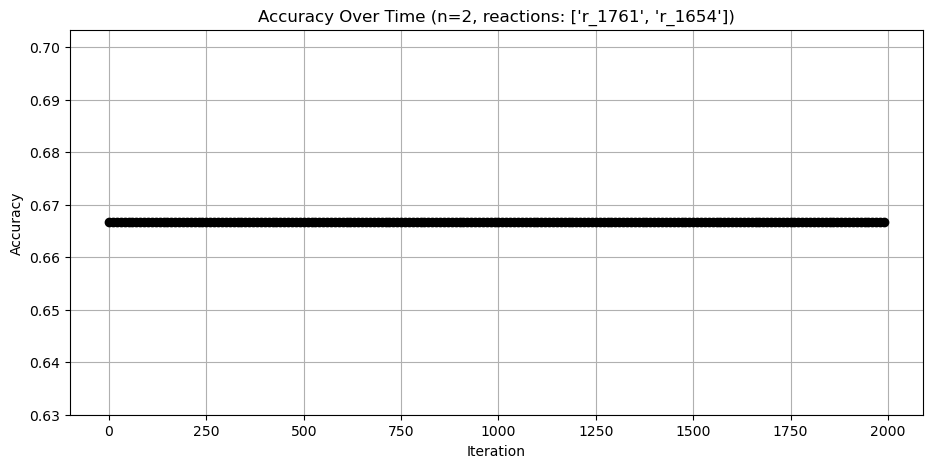

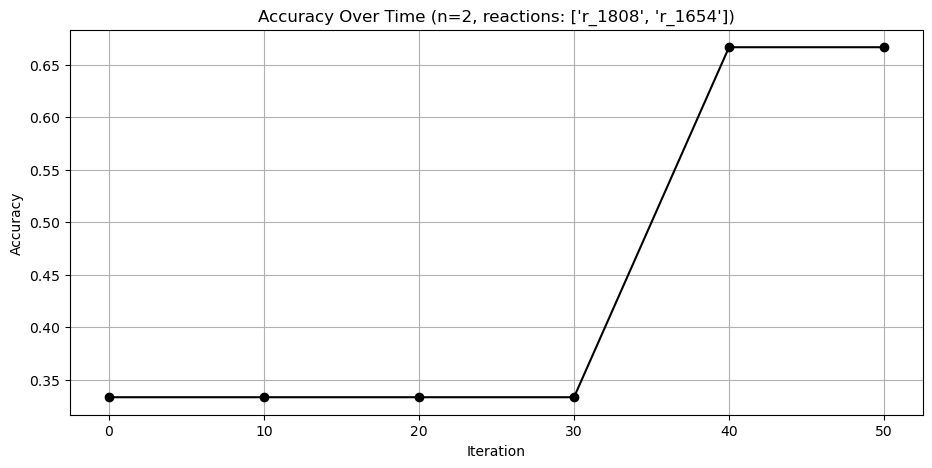

In [21]:
%%time

criteria_2_higher = {'r_2111':1,'r_1714':-1,'r_1761':1}
objectives_higher = ['r_2111', 'r_1714', 'r_1761', 'r_1808', 'r_1654']

result_higher_2 = optimize_objective_from_qualitative_criteria(model,objectives_higher,criteria_2_higher,bounds=None,initial_temp = 7000, max_iter=1000)

In [22]:
scaled_objective, accuracy, criteria2_log_df, description, fig, agreement_df = result_higher_2

%store criteria2_log_df

criteria2_log_df.to_csv('iterative_criteria_2_log.csv', index=False)

Stored 'criteria2_log_df' (DataFrame)


Optimisation: User would like to fit an objective function including reactions: ['r_2111', 'r_1714', 'r_1761', 'r_1808', 'r_1654'] to predict a flux distribution best matching experimental data, measuring 4 reactions
Trying qualitative match via equal-weight objectives first...
Testing equal weight combinations for n=1...
Testing equal weight combinations for n=2...
Testing equal weight combinations for n=3...
Testing equal weight combinations for n=4...
Testing equal weight combinations for n=5...
No exact match found with equal weights. Starting simulated annealing...
Trying Dual Annealing with all combinations of 2 reactions...
Trying Dual Annealing with all combinations of 3 reactions...
1 perfect match(es) found via dual annealing for n=3
CPU times: total: 1d 5h 19min 1s
Wall time: 1d 5h 25min 22s


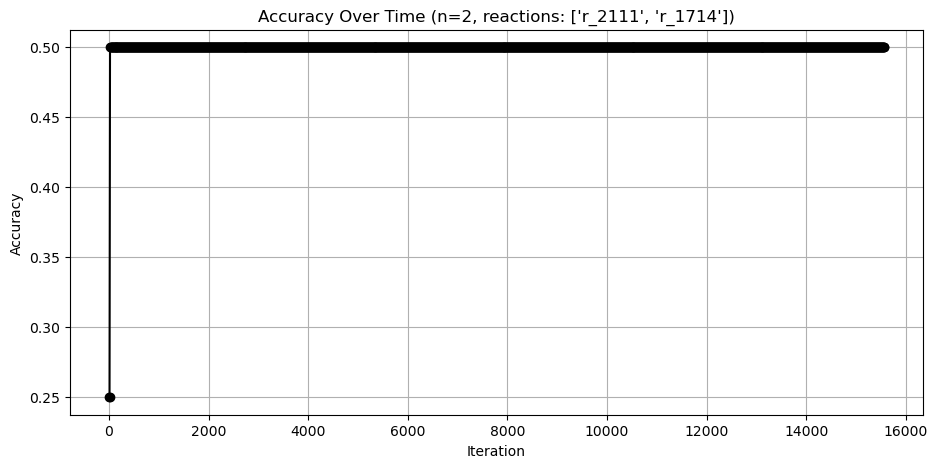

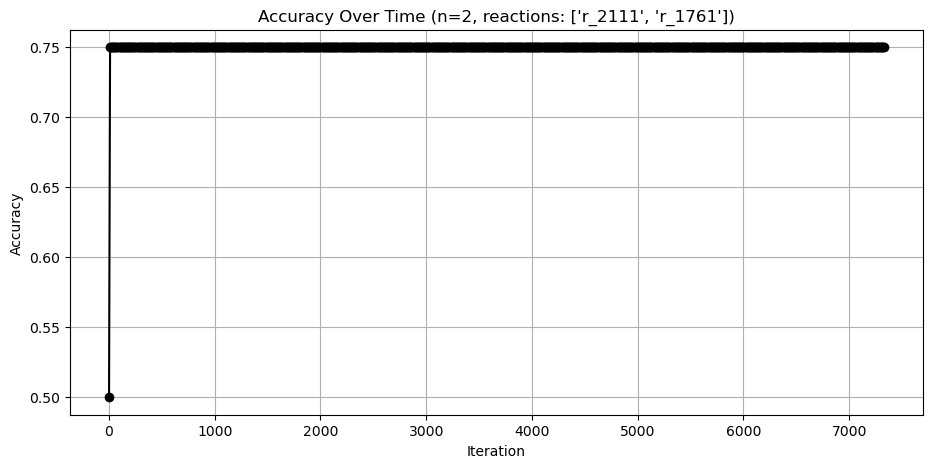

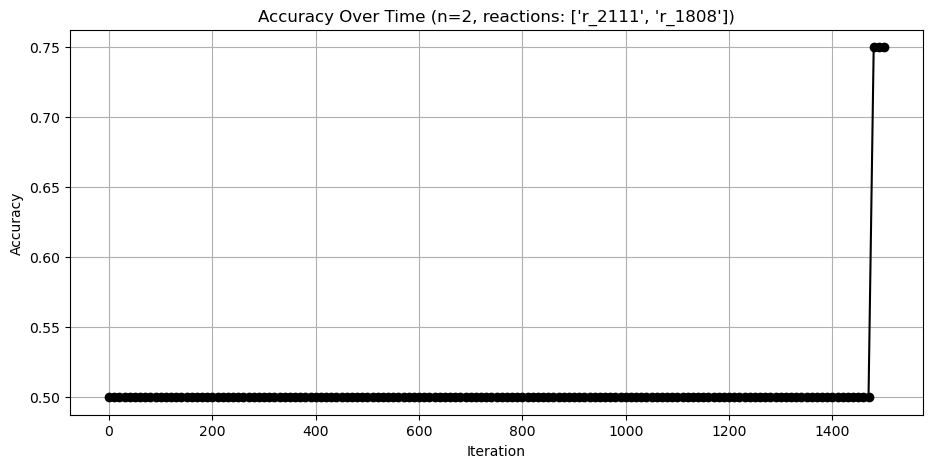

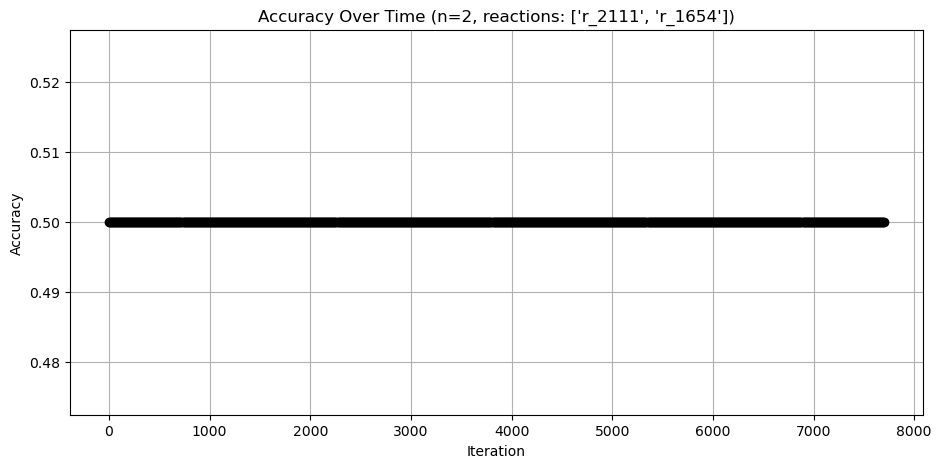

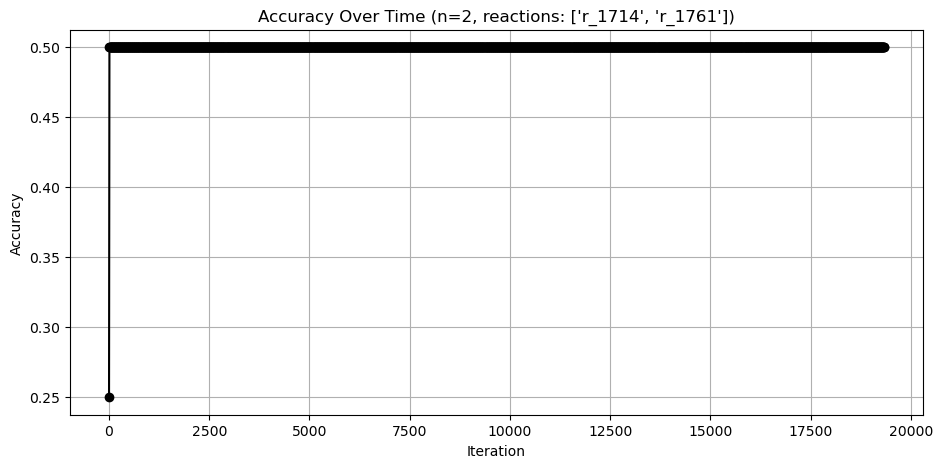

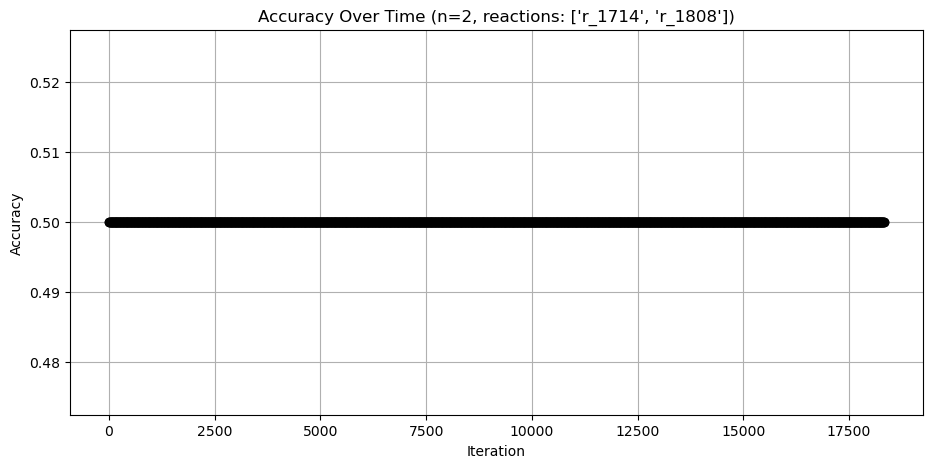

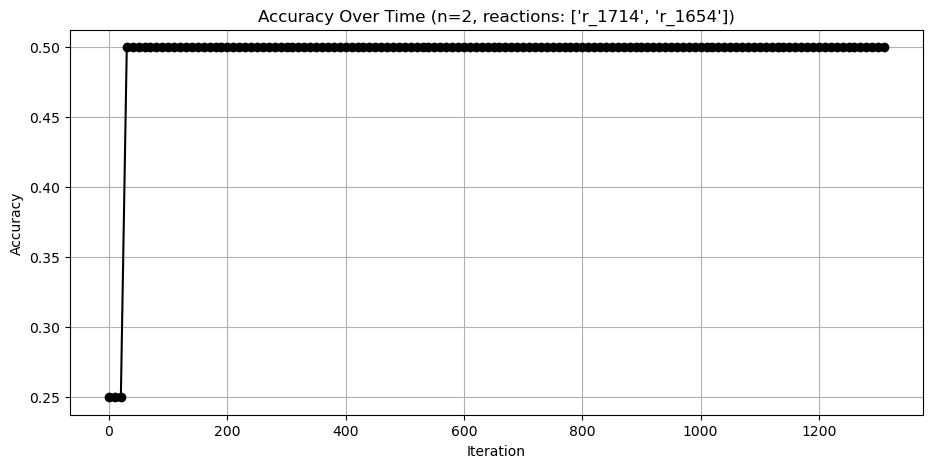

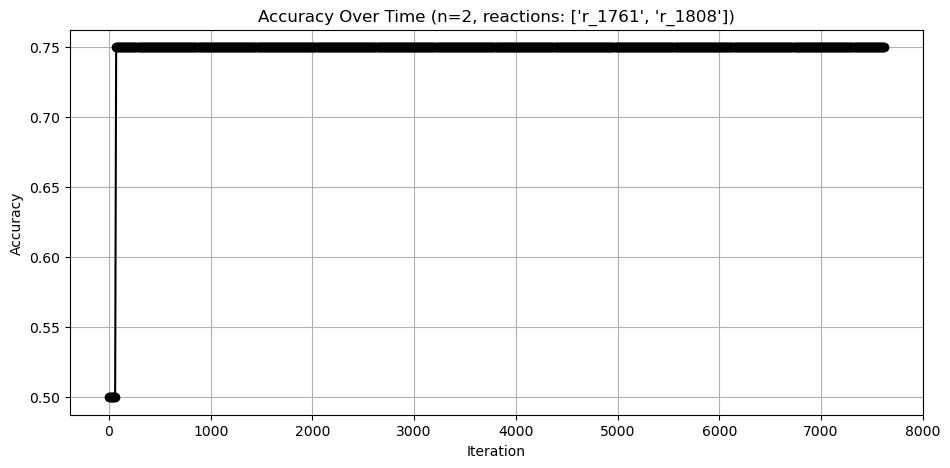

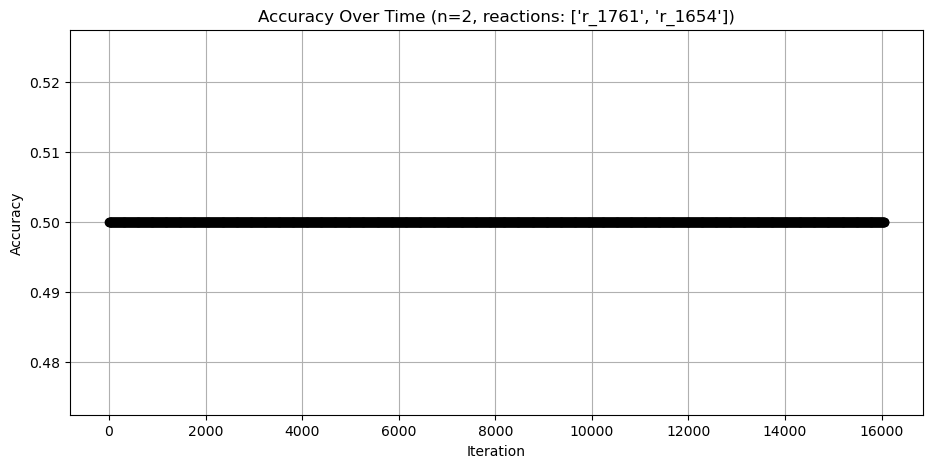

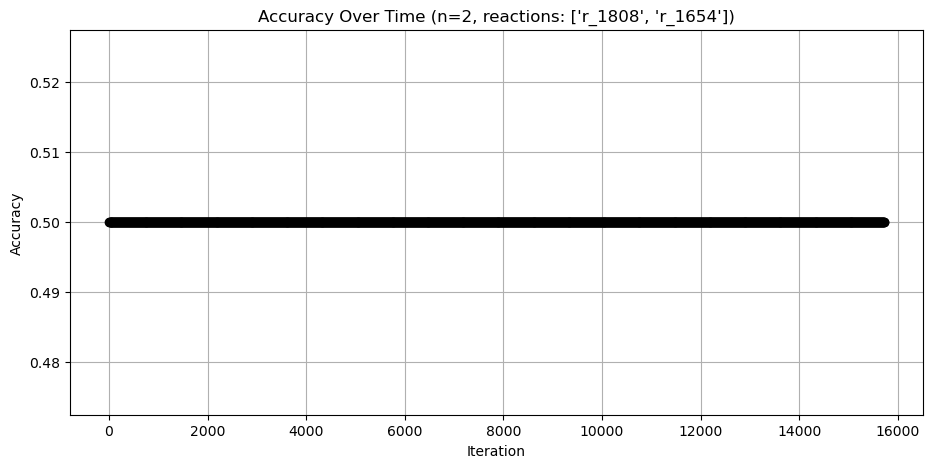

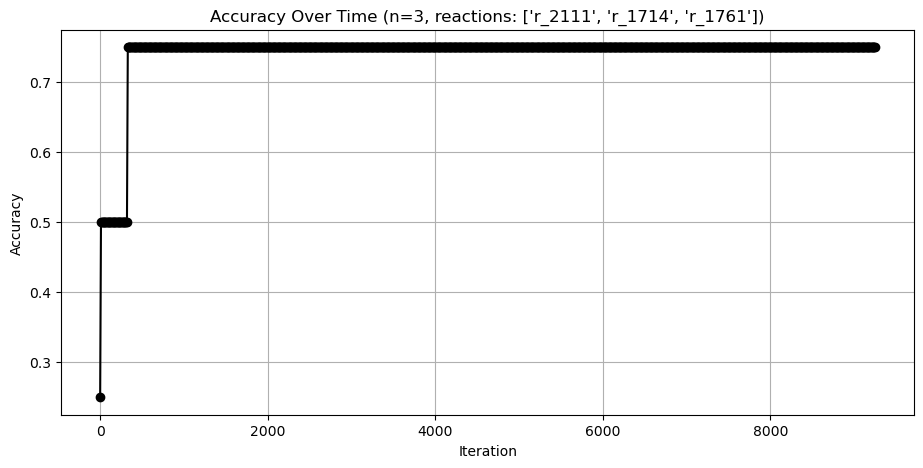

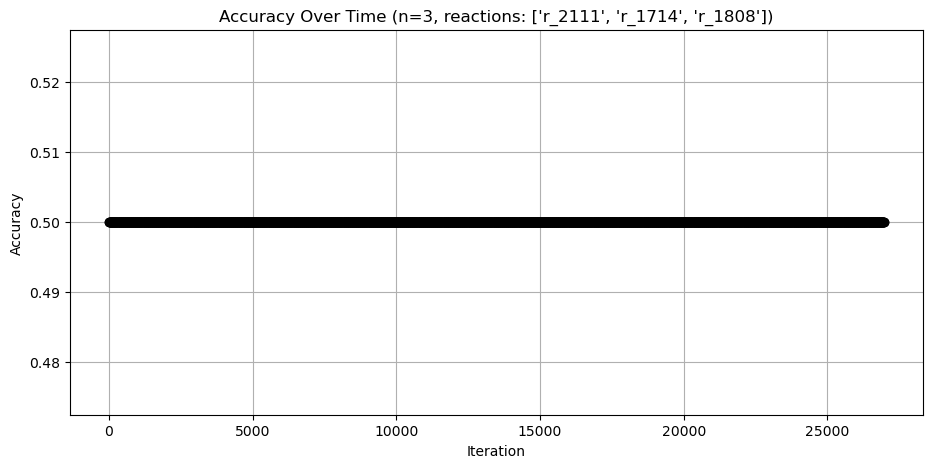

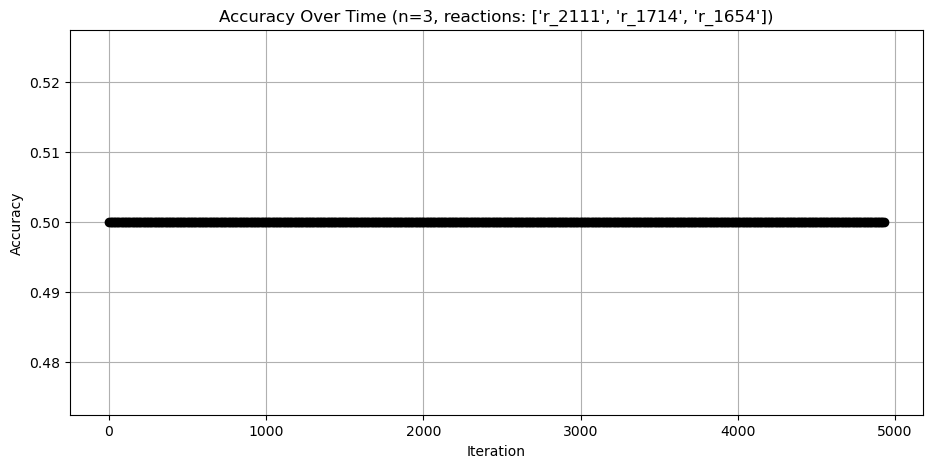

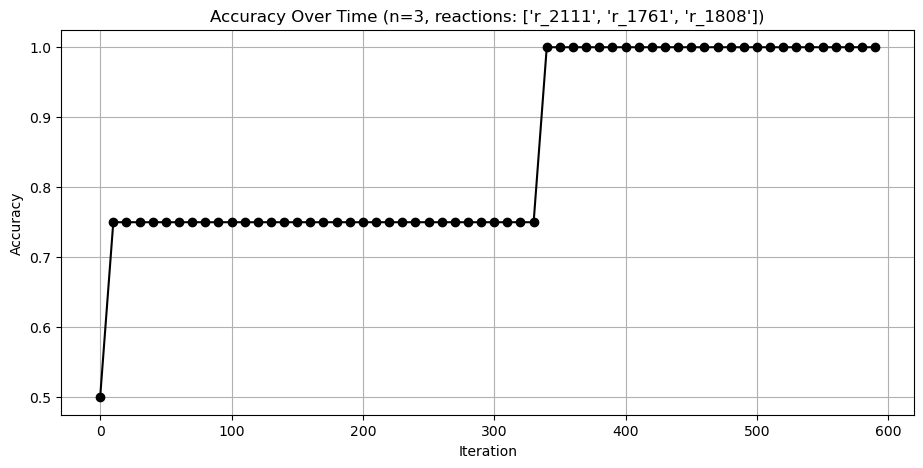

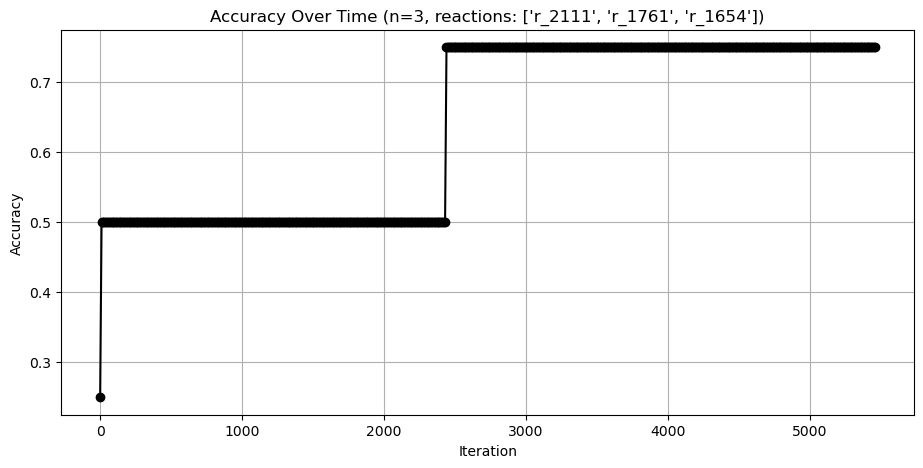

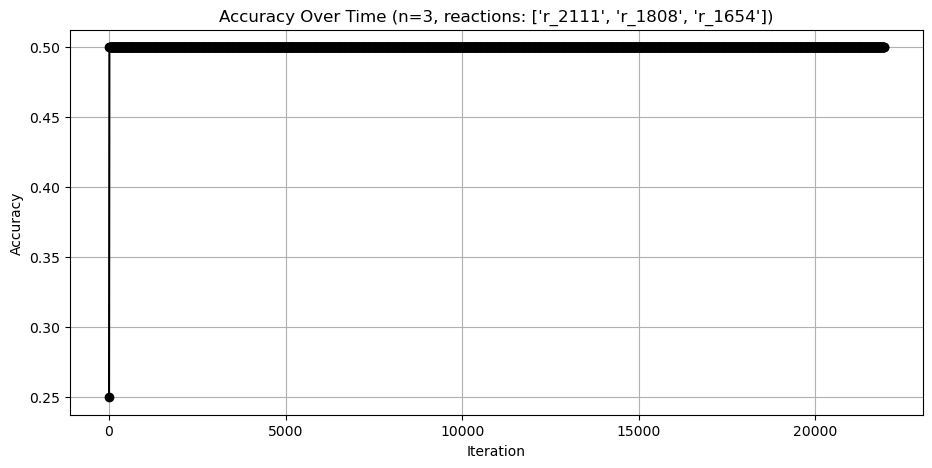

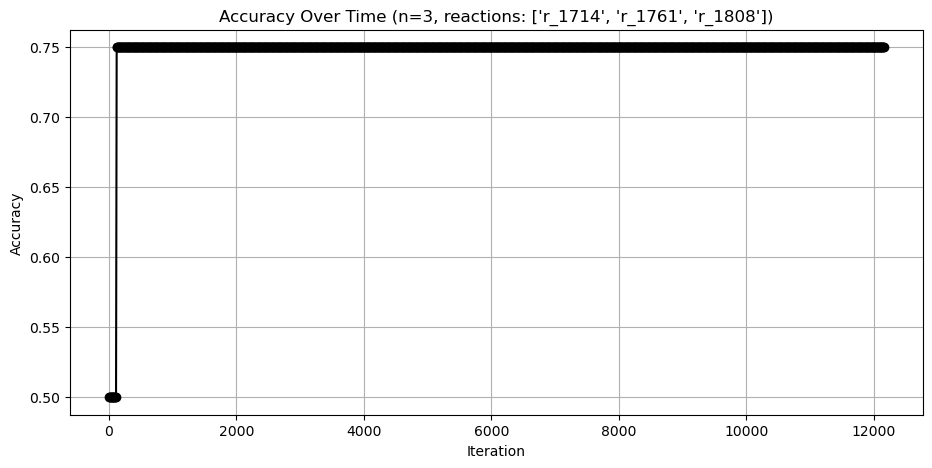

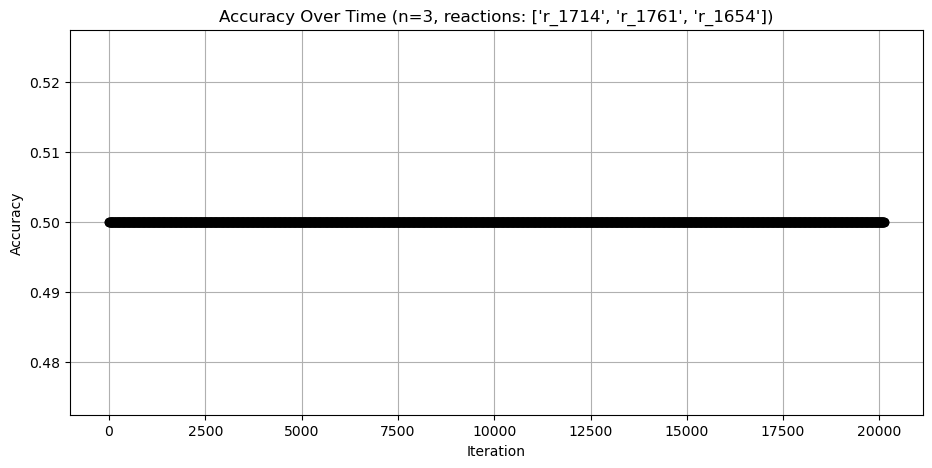

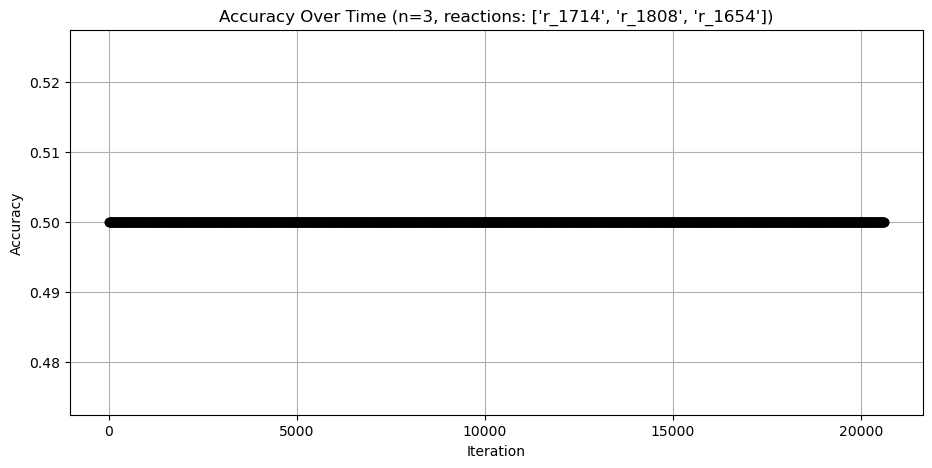

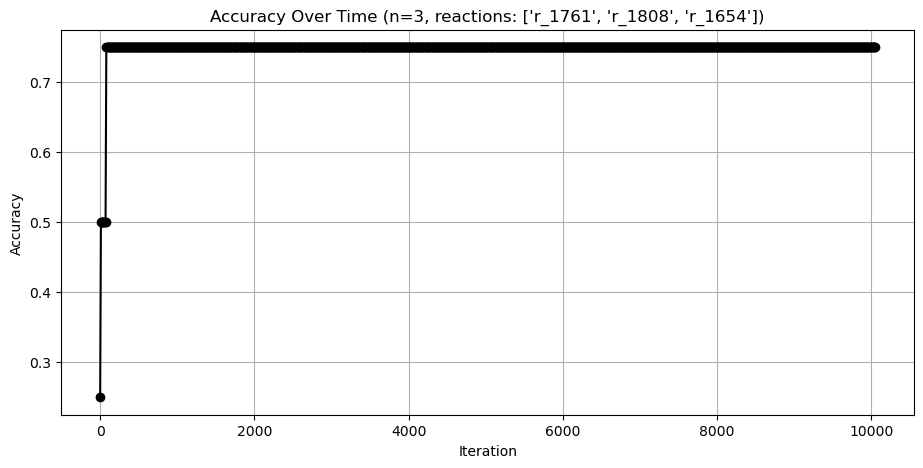

In [23]:
%%time

criteria_3_higher = {'r_2111':1,'r_1714':-1,'r_1761':1, 'r_1808':1}
objectives_higher = ['r_2111', 'r_1714', 'r_1761', 'r_1808', 'r_1654']

result_higher_3 = optimize_objective_from_qualitative_criteria(model,objectives_higher,criteria_3_higher,bounds=None, initial_temp = 9000, max_iter=5000)

In [24]:
scaled_objective, accuracy, criteria3_log_df, description, fig, agreement_df = result_higher_3

%store criteria3_log_df

criteria3_log_df.to_csv('iterative_criteria_3_log.csv', index=False)

Stored 'criteria3_log_df' (DataFrame)
